In [1]:
import tensorflow as tf
import numpy as np

import random, math, itertools
from collections import defaultdict, deque, Counter

import matplotlib.pylab as plt

%load_ext autoreload
%autoreload 2

In [20]:
m = 512 # code weight matrix dimension
n = 1024 # visit weight matrix dimension
code_len = 5

max_iter = 2000
max_iter_progress_report = 100

batch_size = 256

In [21]:
import data.coril as coril
import data.vectorize as vectorize

In [22]:
observations, dictionary, reverse_dictionary = coril.read_visits("/mnt/veracrypt1/val/slv_events.seq", code_len=code_len)
C = len(dictionary)
print(C)

11410


In [23]:
med2vec = tf.Graph()

with med2vec.as_default():
    
    # x represents a number of visits visits
    x = tf.placeholder(tf.float32, shape=(None, C))
    
    # y represents the context of a visit e.g., a label in another visit
    y = tf.placeholder(tf.float32, shape=(None, C))
    
    # the bias term for the code representation
    b_c = tf.Variable(tf.zeros([m]), name="b_c")
    
    # the code vector
    # each code 1..C, is represented by a vector of m elements
    # initialized with a small random number
    W_c = tf.Variable(tf.random_uniform([C, m], -0.01, 0.01), name="W_c")
    
    # the intermidiate visit representation is given by the
    # sum of the visits (each row of x) multiplied by the code vector 
    # which is a column of W_c
    u_t = tf.nn.relu(tf.matmul(x, W_c) + b_c, name="u_t")
    
    # the bias term for the visit representation
    b_v = tf.Variable(tf.zeros([n]))
    
    # the visit weight matrix.  
    W_v = tf.Variable(tf.random_uniform([m, n], -0.01, 0.01))
        
    v_t = tf.nn.relu(tf.matmul(u_t, W_v) + b_v, name="v_t")
    
    b_s = tf.Variable(tf.zeros([C]))
    W_s = tf.Variable(tf.random_uniform([n, C], -0.01, 0.01))
    
    y_t = tf.matmul(v_t, W_s) + b_s
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_t, labels=y))
   
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    init = tf.global_variables_initializer()
    
    
with tf.Session(graph=med2vec) as session:

    init.run()
    loss_values = []
    tmp_loss = []
    
    #vec_obs = vectorize.simple_input_output_generator(
    #    observations, dictionary, max_skip_ahead=5, random_output=False)
    vec_obs = vectorize.random_input_output_generator(
        observations, dictionary, max_skip=2, sample=3)
    vec_cycle = itertools.cycle(vec_obs)
    for i in range(max_iter):
        x_data, y_data = vectorize.generate_batch(vec_cycle, batch_size=batch_size)
        _, loss_value,  = session.run([optimizer, loss], feed_dict= {x: x_data, y: y_data})

        tmp_loss.append(loss_value)
        if i % max_iter_progress_report == 0:
            print(max_iter_progress_report, " iterations", np.mean(tmp_loss))
            loss_values.append(np.mean(tmp_loss))
            tmp_loss = []
        
    W_c_val = W_c.eval()
    W_v_val = W_v.eval()
    b_c_val = b_c.eval()

100  iterations 9.34224
100  iterations 7.84036
100  iterations 6.53659
100  iterations 6.27025
100  iterations 6.15518
100  iterations 6.13603
100  iterations 6.02837
100  iterations 6.01079
100  iterations 6.08147
100  iterations 6.05173
100  iterations 6.10669
100  iterations 5.97566
100  iterations 6.13923
100  iterations 6.11744
100  iterations 5.92568
100  iterations 5.86397
100  iterations 5.88184
100  iterations 5.88414
100  iterations 5.83289
100  iterations 5.76464


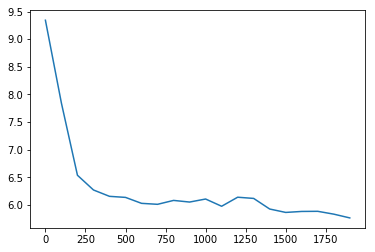

In [24]:
plt.plot(range(0, max_iter, max_iter_progress_report), loss_values)
plt.show()

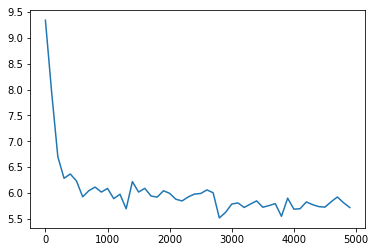

In [6]:
plt.plot(range(0, max_iter, max_iter_progress_report), loss_values)
plt.show()

In [25]:
def read_translate(f, code_len=None):
    with open(f) as lines:
        d = {}
        for code, translation in map(lambda x: x.strip().split("|"), lines):
            d[code[:code_len] if code_len is not None else code] = translation
        return d
icd_translator = read_translate("icd10.txt", code_len=code_len)

In [26]:
def make_translator(*translators):
    def f(code):
        r = code
        for translator in translators:
            r = translator[code]
            if r is None:
                return code
            code = r
        return code
    return f

translator = make_translator(reverse_dictionary, icd_translator)
translator(0)

'Hjärtinsufficiens, ospecificerad'

In [29]:
list(map(lambda f: translator(f), np.argsort(np.maximum(W_c_val, 0)[:,42])[::-1][:10]))

['Progressiv systemisk skleros',
 'Psykiska störningar och beteendestörningar orsakade av alkohol, skadligt bruk',
 'Schizofreni, ospecificerad',
 'Malign tumör i bröstkörtel i den egna sjukhistorien',
 'Paranoid schizofreni',
 'Perkutan eller sluten reposition av luxerad höftledsprotes',
 'Vänster sida',
 'Sekundär malign tumör i ben och benmärg',
 'Upprättande av vårdplan vid tvångsvård (i)',
 'Upprättande av strukturerad vård- och omsorgsplan (i)']

In [17]:
icd_translator

{'A00': 'Kolera, ospecificerad',
 'A01': 'Paratyfoidfeber, ospecificerad',
 'A02': 'Andra salmonellainfektioner, ospecificerade',
 'A03': 'Shigellos, ospecificerad',
 'A04': 'Bakteriell tarminfektion, ospecificerad',
 'A05': 'Matförgiftning orsakad av bakterier, ospecificerad',
 'A06': 'Amöbainfektion, ospecificerad',
 'A07': 'Protozosjukdom i tarmen, ospecificerad',
 'A08': 'Andra specificerade tarminfektioner',
 'A09': 'Gastroenterit och kolit av icke specificerad orsak',
 'A15': 'Tuberkulos i andningsorganen, ospecificerad, verifierad bakteriologiskt och histologiskt',
 'A16': 'Tuberkulos i icke specificerat andningsorgan utan uppgift om bakteriologisk eller histologisk verifikation',
 'A17': 'Tuberkulos i nervsystemet, ospecificerad',
 'A18': 'Tuberkulos i andra specificerade organ',
 'A19': 'Miliartuberkulos, ospecificerad',
 'A20': 'Pest, ospecificerad',
 'A21': 'Tularemi, ospecificerad',
 'A22': 'Antrax, ospecificerad',
 'A23': 'Brucellos, ospecificerad',
 'A24': 'Melioidos, osp

KeyboardInterrupt: 